In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Read Train data

In [62]:

train_home_team_statistics_df = pd.read_csv('./train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./train_away_team_statistics_df.csv', index_col=0)
train_home_player_statistics_df = pd.read_csv('./train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('./train_away_player_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./Y_train.csv', index_col=0)

In [56]:
# Cleaning NaN values
def drop_NaN_columns(df, column_of_interest):
    col_vals = np.unique(df[column_of_interest].tolist())
    colsToDrop = []
    for val in col_vals:
        NaNcols = df[df[column_of_interest] == val].isna().all()
        for index in NaNcols.keys():
            if(NaNcols[index]):
                colsToDrop.append(index)
    return df.drop(np.unique(colsToDrop), axis=1)

def replace_NaN_values(df, column_of_interest):
    col_vals = np.unique(df[column_of_interest].tolist())
    for val in col_vals:
        new_df = df[df[column_of_interest] == val].drop([column_of_interest], axis=1).replace({np.inf:np.nan,-np.inf:np.nan})
        new_df.fillna(new_df.mean(), inplace=True)
        df.loc[df[column_of_interest] == val,:] = new_df
        #print(df)

def test_NaN_values(df):
    NaNcols = df.isna().any()
    for index in NaNcols.keys():
        if(NaNcols[index]):
            return True, index
    return False

def clean_data(df, column_of_interest, NaN_columns):
    clean_df = df.drop(NaN_columns, axis=1)
    clean_df = drop_NaN_columns(clean_df, column_of_interest)
    replace_NaN_values(clean_df, column_of_interest)
    return clean_df.drop([column_of_interest], axis=1)

train_home_player_statistics_df = clean_data(train_home_player_statistics_df, "LEAGUE", ["TEAM_NAME", "POSITION", "PLAYER_NAME"])
train_away_player_statistics_df = clean_data(train_away_player_statistics_df, "LEAGUE", ["TEAM_NAME", "POSITION", "PLAYER_NAME"])
train_home_team_statistics_df = clean_data(train_home_team_statistics_df, "LEAGUE", ["TEAM_NAME"])
train_away_team_statistics_df = clean_data(train_away_team_statistics_df, "LEAGUE", ["TEAM_NAME"])

## Try team length selection by chosen criterion

In [83]:
# format player data
def flatten_df(df):
    df.index = df.index + 1
    df_out = df.stack()
    df_out.index = df_out.index.map('{0[1]}_{0[0]}'.format)
    return df_out.to_frame().T

def format_df(df, players_by_match=10):
    formatted_df = pd.DataFrame()
    indices = np.unique(df.index)
    for index in indices:
        new_df = (np.argsort(df['PLAYER_BIG_CHANCES_CREATED_season_sum'][index] - df['PLAYER_BIG_CHANCES_MISSED_season_sum'][index]))
        new_df = new_df.reset_index()
        new_df = flatten_df(df.loc[index,:].reset_index().loc[new_df[0][:players_by_match],:].reset_index().drop(["index", "ID"], axis=1))
        formatted_df = pd.concat([formatted_df, new_df])
    return formatted_df

#print(train_away_player_statistics_df)
train_away_player_statistics_df = format_df(train_away_player_statistics_df)
train_away_player_statistics_df = train_away_player_statistics_df.reset_index().drop(["index"],axis=1)
train_home_player_statistics_df = format_df(train_home_player_statistics_df)
train_home_player_statistics_df = train_home_player_statistics_df.reset_index().drop(["index"],axis=1)

# Getting final data
train_home = train_home_team_statistics_df.join(train_home_player_statistics_df)
train_away = train_away_team_statistics_df.join(train_away_player_statistics_df)

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data = train_home.join(train_away)
print(train_data)

       HOME_TEAM_SHOTS_TOTAL_season_sum  HOME_TEAM_SHOTS_INSIDEBOX_season_sum  \
ID                                                                              
0                                   3.0                              2.000000   
1                                   6.0                              8.000000   
2                                   4.0                              2.000000   
3                                   7.0                              5.000000   
4                                   3.0                              3.000000   
...                                 ...                                   ...   
12298                               4.0                              2.000000   
12299                               4.0                              2.000000   
12300                               4.0                              3.000000   
12301                               2.0                              5.365714   
12302                       

In [5]:
train_y = np.argmax(train_scores.to_numpy(), axis=1)
print(np.unique(train_y, return_counts=True))

(array([0, 1, 2], dtype=int64), array([5356, 3186, 3761], dtype=int64))


In [9]:
train_data = train_home_team_statistics_df

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [12]:
val, counts_train = np.unique(y_train, return_counts=True)
val, counts_test = np.unique(y_test, return_counts=True)
val, counts_valid = np.unique(y_valid, return_counts=True)

print(val, " , train : ", counts_train/np.sum(counts_train), " , valid : ", counts_valid/np.sum(counts_valid), " , test : ", counts_test/np.sum(counts_test))

[0 1 2]  , train :  [0.43096659 0.26076464 0.30826877]  , valid :  [0.44692737 0.26053834 0.29253428]  , test :  [0.44006501 0.25193011 0.30800488]


In [88]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:1.08783	eval-mlogloss:1.09593
[1]	train-mlogloss:1.07653	eval-mlogloss:1.09328
[2]	train-mlogloss:1.06552	eval-mlogloss:1.09067
[3]	train-mlogloss:1.05527	eval-mlogloss:1.08859
[4]	train-mlogloss:1.04560	eval-mlogloss:1.08586
[5]	train-mlogloss:1.03558	eval-mlogloss:1.08366
[6]	train-mlogloss:1.02649	eval-mlogloss:1.08165
[7]	train-mlogloss:1.01727	eval-mlogloss:1.07927
[8]	train-mlogloss:1.00849	eval-mlogloss:1.07727
[9]	train-mlogloss:0.99992	eval-mlogloss:1.07509
[10]	train-mlogloss:0.99054	eval-mlogloss:1.07357
[11]	train-mlogloss:0.98233	eval-mlogloss:1.07132
[12]	train-mlogloss:0.97312	eval-mlogloss:1.06965
[13]	train-mlogloss:0.96514	eval-mlogloss:1.06818
[14]	train-mlogloss:0.95670	eval-mlogloss:1.06684
[15]	train-mlogloss:0.94902	eval-mlogloss:1.06520
[16]	train-mlogloss:0.94086	eval-mlogloss:1.06385
[17]	train-mlogloss:0.93309	eval-mlogloss:1.06214
[18]	train-mlogloss:0.92518	eval-mlogloss:1.06071
[19]	train-mlogloss:0.91736	eval-mlogloss:1.05903
[20]	train

In [96]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = np.argmax(predictions, axis=1)

print(np.round(accuracy_score(predictions,y_test),4))

0.4393


## Linear regression test

In [102]:
from sklearn import linear_model

lin_model = linear_model.LogisticRegression()

lin_model.fit(X_train, y_train)

LogisticRegression()

In [105]:
y_pred = lin_model.predict(X_valid)
print(y_pred)
print(np.round(accuracy_score(y_pred,y_valid),4))

[0 0 0 ... 2 0 0]
0.4408


## Ensemble model (by team length)

In [22]:
def flatten_df(df):
    new_df = df.copy()
    new_df.index = new_df.index + 1
    df_out = new_df.stack()
    df_out.index = df_out.index.map('{0[1]}_{0[0]}'.format)
    return df_out.to_frame().T

def format_df(df):
    formatted_df = [pd.DataFrame() for i in range(10, 30)]
    indices = np.unique(df.index)
    for index in indices:
        n_players = len(df.loc[index,:])
        new_df = flatten_df(df.loc[index,:].reset_index().drop(["ID"], axis=1))
        new_df.insert(1, "ID", [index], True)
        #new_df = flatten_df(df.loc[index,:].reset_index().loc[new_df[0][:players_by_match],:].reset_index().drop(["index", "ID"], axis=1))
        formatted_df[n_players-10] = pd.concat([formatted_df[n_players-10], new_df])
    
    for i in range(10, 30):
        if(formatted_df[i-10].empty == False):
            formatted_df[i-10].set_index("ID", inplace=True)

    return formatted_df
        
train_away_player_statistics_dfs = format_df(train_away_player_statistics_df)
train_home_player_statistics_dfs = format_df(train_home_player_statistics_df)

In [33]:
train_datas = []
for i in range(20):
    if(train_home_player_statistics_dfs[i].empty == False):
        print(train_home_team_statistics_df)
        print(train_home_player_statistics_dfs[i])
        train_datas.append([])
        for j in range(20):
            if(train_away_player_statistics_dfs[j].empty == False):
                train_home = train_home_team_statistics_df.join(train_home_player_statistics_dfs[i], how="right")
                train_away = train_away_team_statistics_df.join(train_away_player_statistics_dfs[j], how="right")

                train_home.columns = 'HOME_' + train_home.columns
                train_away.columns = 'AWAY_' + train_away.columns

                train_data = train_home.join(train_away, how="inner")
                if(train_data.empty):
                    train_datas[i].append(None)
                else:
                    train_datas[i].append(train_home.join(train_away, how="inner"))
            else:
                train_datas[i].append(None)
    else:
        train_datas.append(None)
        

       TEAM_SHOTS_TOTAL_season_sum  TEAM_SHOTS_INSIDEBOX_season_sum  \
ID                                                                    
0                              3.0                         2.000000   
1                              6.0                         8.000000   
2                              4.0                         2.000000   
3                              7.0                         5.000000   
4                              3.0                         3.000000   
...                            ...                              ...   
12298                          4.0                         2.000000   
12299                          4.0                         2.000000   
12300                          4.0                         3.000000   
12301                          2.0                         5.365714   
12302                          2.0                         3.000000   

       TEAM_SHOTS_OFF_TARGET_season_sum  TEAM_SHOTS_ON_TARGET_season_sum  \


In [38]:
X_train, y_train, X_test, y_test = [], [], [], []

for i in range(20):
    if(train_datas[i] is None):
        X_train.append(None)
        X_test.append(None)
        y_train.append(None)
        y_test.append(None)
        continue
    else:
        X_train.append([])
        X_test.append([])
        y_train.append([])
        y_test.append([])

    for j in range(20):
        if(not(train_datas[i][j] is None)):
            print(i+10, " : ", j+10, " :: ", len(train_datas[i][j]), " ; ", len(train_datas[i][j].columns))
            if(len(train_datas[i][j]) > 10):
                mask = train_scores.index.isin(train_datas[i][j].index)
                train_score = train_scores[mask]
                X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = model_selection.train_test_split(train_datas[i][j], train_score, train_size=0.9, random_state=42)
                X_train[i].append(X_train_tmp)
                X_test[i].append(X_test_tmp)
                y_train[i].append(y_train_tmp)
                y_test[i].append(y_test_tmp)
            else:
                X_train[i].append(None)
                X_test[i].append(None)
                y_train[i].append(None)
                y_test[i].append(None)
        else:
            X_train[i].append(None)
            X_test[i].append(None)
            y_train[i].append(None)
            y_test[i].append(None)

15  :  18  ::  3  ;  8594
16  :  17  ::  1  ;  8594
16  :  18  ::  9  ;  8846
16  :  19  ::  1  ;  9098
16  :  23  ::  1  ;  10106
17  :  17  ::  13  ;  8846
17  :  18  ::  178  ;  9098
17  :  19  ::  6  ;  9350
17  :  20  ::  8  ;  9602
17  :  21  ::  1  ;  9854
17  :  23  ::  3  ;  10358
18  :  14  ::  1  ;  8342
18  :  15  ::  4  ;  8594
18  :  16  ::  20  ;  8846
18  :  17  ::  234  ;  9098
18  :  18  ::  6820  ;  9350
18  :  19  ::  82  ;  9602
18  :  20  ::  87  ;  9854
18  :  21  ::  25  ;  10106
18  :  22  ::  10  ;  10358
18  :  23  ::  8  ;  10610
19  :  17  ::  7  ;  9350
19  :  18  ::  82  ;  9602
19  :  19  ::  56  ;  9854
19  :  20  ::  112  ;  10106
19  :  21  ::  43  ;  10358
19  :  22  ::  24  ;  10610
19  :  23  ::  26  ;  10862
20  :  16  ::  3  ;  9350
20  :  17  ::  6  ;  9602
20  :  18  ::  83  ;  9854
20  :  19  ::  149  ;  10106
20  :  20  ::  1274  ;  10358
20  :  21  ::  67  ;  10610
20  :  22  ::  71  ;  10862
20  :  23  ::  101  ;  11114
21  :  16  ::  1  ; 

## Ensemble Multi-class Logistic regression

In [43]:
from sklearn import linear_model

lin_model = []

for i in range(20):
    if(X_train[i] is None):
        lin_model.append(None)
        continue
    else:
        lin_model.append([])

    for j in range(20):
        if(not(X_train[i][j] is None)):
            model = linear_model.LogisticRegression()
            model.fit(X_train[i][j], np.argmax(y_train[i][j].to_numpy(), axis=1))
            lin_model[i].append(model)
        else:
            lin_model[i].append(None)

In [51]:
# test the model
results = []
for i in range(20):
    if(X_test[i] is None):
        results.append(None)
        continue
    else:
        results.append([])

    for j in range(20):
        if(not(X_test[i][j] is None)):
            predictions = lin_model[i][j].predict(X_test[i][j])
            print(i+10, " : ", j+10, " :: ", len(y_test[i][j]), " ; ", accuracy_score(predictions, np.argmax(y_test[i][j].to_numpy(), axis=1)))
        else:
            results[i].append(None)

#print(results)

17  :  17  ::  2  ;  0.5
17  :  18  ::  18  ;  0.3333333333333333
18  :  16  ::  2  ;  0.0
18  :  17  ::  24  ;  0.4583333333333333
18  :  18  ::  682  ;  0.41348973607038125
18  :  19  ::  9  ;  0.4444444444444444
18  :  20  ::  9  ;  0.3333333333333333
18  :  21  ::  3  ;  0.3333333333333333
19  :  18  ::  9  ;  0.4444444444444444
19  :  19  ::  6  ;  0.3333333333333333
19  :  20  ::  12  ;  0.5
19  :  21  ::  5  ;  0.2
19  :  22  ::  3  ;  0.6666666666666666
19  :  23  ::  3  ;  0.0
20  :  18  ::  9  ;  0.4444444444444444
20  :  19  ::  15  ;  0.5333333333333333
20  :  20  ::  128  ;  0.46875
20  :  21  ::  7  ;  0.42857142857142855
20  :  22  ::  8  ;  0.375
20  :  23  ::  11  ;  0.36363636363636365
21  :  18  ::  3  ;  0.6666666666666666
21  :  19  ::  4  ;  0.5
21  :  20  ::  8  ;  0.625
21  :  21  ::  10  ;  0.8
21  :  22  ::  8  ;  0.625
21  :  23  ::  12  ;  0.4166666666666667
22  :  19  ::  3  ;  0.0
22  :  20  ::  7  ;  0.42857142857142855
22  :  21  ::  12  ;  0.5
22  :  22

## Ensemble Multi-class XGB Trees

In [52]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }




num_round = 10000

bst_model = []

for i in range(20):
    if(X_test[i] is None):
        bst_model.append(None)
        continue
    else:
        bst_model.append([])

    for j in range(20):
        if(not(X_test[i][j] is None)):
            d_train = xgb.DMatrix(X_train[i][j].replace({0:np.nan}), np.argmax(y_train[i][j].to_numpy(), axis=1))
            d_valid = xgb.DMatrix(X_test[i][j].replace({0:np.nan}), np.argmax(y_test[i][j].to_numpy(), axis=1))
            evallist = [(d_train, 'train'), (d_valid, 'eval')]

            bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)
            bst_model[i].append(bst)
        else:
            bst_model[i].append(None)

[0]	train-mlogloss:1.07142	eval-mlogloss:1.11229
[1]	train-mlogloss:1.04509	eval-mlogloss:1.12609
[2]	train-mlogloss:1.01958	eval-mlogloss:1.14001
[3]	train-mlogloss:0.99486	eval-mlogloss:1.15404
[4]	train-mlogloss:0.97090	eval-mlogloss:1.16818
[5]	train-mlogloss:0.94767	eval-mlogloss:1.18243
[6]	train-mlogloss:0.92514	eval-mlogloss:1.19677
[7]	train-mlogloss:0.90329	eval-mlogloss:1.21121
[8]	train-mlogloss:0.88209	eval-mlogloss:1.22574
[9]	train-mlogloss:0.86152	eval-mlogloss:1.24036
[10]	train-mlogloss:0.84155	eval-mlogloss:1.25506
[11]	train-mlogloss:0.82216	eval-mlogloss:1.26984
[12]	train-mlogloss:0.80333	eval-mlogloss:1.28469
[13]	train-mlogloss:0.78504	eval-mlogloss:1.29962
[14]	train-mlogloss:0.76727	eval-mlogloss:1.31460
[15]	train-mlogloss:0.75001	eval-mlogloss:1.32966
[16]	train-mlogloss:0.73323	eval-mlogloss:1.34477
[17]	train-mlogloss:0.71691	eval-mlogloss:1.35994
[18]	train-mlogloss:0.70106	eval-mlogloss:1.37516
[19]	train-mlogloss:0.68564	eval-mlogloss:1.39043
[20]	train

In [60]:
# save the model
for i in range(20):
    if(bst_model[i] is None):
        continue

    for j in range(20):
        if(not(bst_model[i][j] is None)):
            bst_model[i][j].save_model("./Ensemble_multi_XGB/model_"+str(i+10)+"_"+str(j+10))

In [88]:
# validate the model
print(bst_model[11][11].attributes())
results = []
for i in range(20):
    if(X_test[i] is None):
        results.append(None)
        continue
    else:
        results.append([])

    for j in range(20):
        if(not(X_test[i][j] is None)):
            x_test = xgb.DMatrix(X_test[i][j])
            predictions_best = np.argmax(bst_model[i][j].predict(x_test, iteration_range=(0, bst_model[i][j].best_iteration)), axis=1)
            predictions_last = np.argmax(bst_model[i][j].predict(x_test), axis=1)
            print(i+10, " : ", j+10, " :: ", len(y_test[i][j]), " ; ", accuracy_score(predictions_best, np.argmax(y_test[i][j].to_numpy(), axis=1)), " , ", accuracy_score(predictions_last, np.argmax(y_test[i][j].to_numpy(), axis=1)), " :::: ", accuracy_score(np.zeros(len(predictions_best)), np.argmax(y_test[i][j].to_numpy(), axis=1)))
        else:
            results[i].append(None)

{'best_iteration': '0', 'best_score': '1.0976983308792114'}
17  :  17  ::  2  ;  0.0  ,  0.0  ::::  0.5
17  :  18  ::  18  ;  0.2222222222222222  ,  0.2222222222222222  ::::  0.3333333333333333
18  :  16  ::  2  ;  0.5  ,  0.5  ::::  0.0
18  :  17  ::  24  ;  0.20833333333333334  ,  0.20833333333333334  ::::  0.4166666666666667
18  :  18  ::  682  ;  0.38563049853372433  ,  0.42961876832844575  ::::  0.43841642228739003
18  :  19  ::  9  ;  0.1111111111111111  ,  0.1111111111111111  ::::  0.3333333333333333
18  :  20  ::  9  ;  0.5555555555555556  ,  0.5555555555555556  ::::  0.2222222222222222
18  :  21  ::  3  ;  0.0  ,  0.0  ::::  0.3333333333333333
19  :  18  ::  9  ;  0.4444444444444444  ,  0.3333333333333333  ::::  0.5555555555555556
19  :  19  ::  6  ;  0.16666666666666666  ,  0.16666666666666666  ::::  0.3333333333333333
19  :  20  ::  12  ;  0.25  ,  0.08333333333333333  ::::  0.5833333333333334
19  :  21  ::  5  ;  0.4  ,  0.4  ::::  0.6
19  :  22  ::  3  ;  0.333333333333333

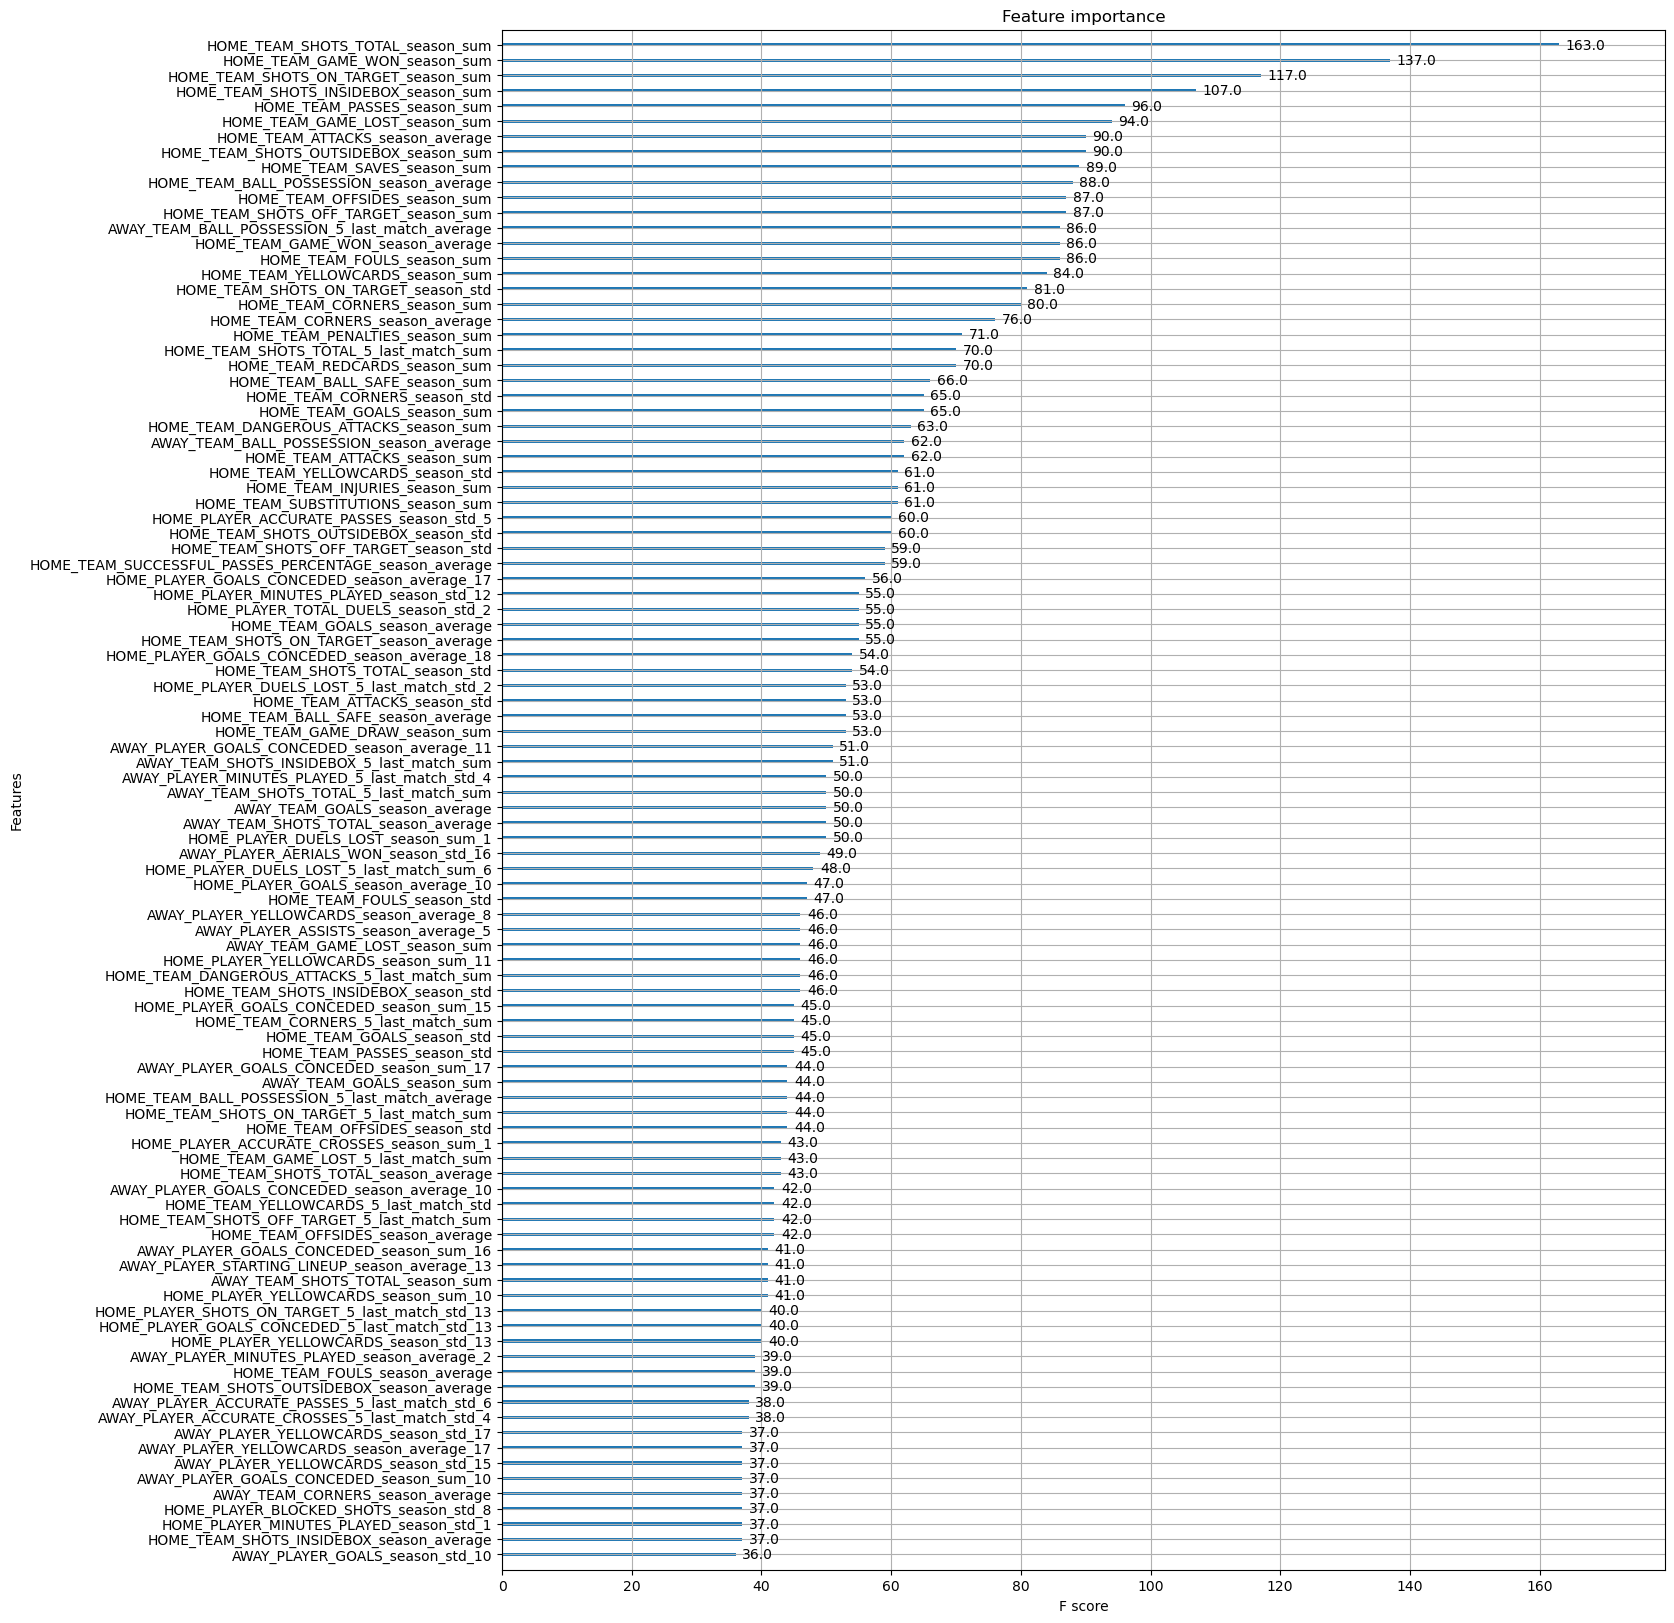

In [67]:
xgb.plot_importance(bst_model[8][8], max_num_features=100)
fig = plt.gcf()
fig.set_size_inches(15, 20)

## KNN

In [86]:
from sklearn import neighbors

knn_model = []

for i in range(20):
    if(X_train[i] is None):
        knn_model.append(None)
        continue
    else:
        knn_model.append([])

    for j in range(20):
        if(not(X_train[i][j] is None)):
            knn = neighbors.KNeighborsClassifier(n_neighbors=11)
            #print(y_train[i][j])
            #print(X_train[i][j])
            knn.fit(X_train[i][j].to_numpy(), np.argmax(y_train[i][j].to_numpy(), axis=1))
            knn_model[i].append(knn)
        else:
            knn_model[i].append(None)

In [87]:
# validate the model
results = []
for i in range(20):
    if(X_test[i] is None):
        results.append(None)
        continue
    else:
        results.append([])

    for j in range(20):
        if(not(X_test[i][j] is None)):
            predictions = knn_model[i][j].predict(X_test[i][j].to_numpy())
            print(i+10, " : ", j+10, " :: ", len(y_test[i][j]), " ; ", accuracy_score(predictions, np.argmax(y_test[i][j].to_numpy(), axis=1)))
        else:
            results[i].append(None)

17  :  17  ::  2  ;  0.5
17  :  18  ::  18  ;  0.2777777777777778
18  :  16  ::  2  ;  0.0
18  :  17  ::  24  ;  0.4166666666666667
18  :  18  ::  682  ;  0.37683284457478006
18  :  19  ::  9  ;  0.2222222222222222
18  :  20  ::  9  ;  0.3333333333333333
18  :  21  ::  3  ;  0.3333333333333333
19  :  18  ::  9  ;  0.4444444444444444
19  :  19  ::  6  ;  0.3333333333333333
19  :  20  ::  12  ;  0.5833333333333334
19  :  21  ::  5  ;  0.2
19  :  22  ::  3  ;  0.3333333333333333
19  :  23  ::  3  ;  0.6666666666666666
20  :  18  ::  9  ;  0.3333333333333333
20  :  19  ::  15  ;  0.4666666666666667
20  :  20  ::  128  ;  0.390625
20  :  21  ::  7  ;  0.5714285714285714
20  :  22  ::  8  ;  0.5
20  :  23  ::  11  ;  0.36363636363636365
21  :  18  ::  3  ;  0.6666666666666666
21  :  19  ::  4  ;  0.25
21  :  20  ::  8  ;  0.25
21  :  21  ::  10  ;  0.7
21  :  22  ::  8  ;  0.375
21  :  23  ::  12  ;  0.25
22  :  19  ::  3  ;  0.0
22  :  20  ::  7  ;  1.0
22  :  21  ::  12  ;  0.5
22  :  22  

## Multi-Class Logistic Regression

In [35]:
train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data = train_home.join(train_away)

train_new_y = np.argmax(train_scores.to_numpy(), axis=1)
print(np.unique(train_new_y, return_counts=True))

(array([0, 1, 2], dtype=int64), array([5356, 3186, 3761], dtype=int64))


In [36]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [38]:
from sklearn import linear_model

lin_model = linear_model.LogisticRegression(C=0.2)

lin_model.fit(X_train.replace({np.nan:0.0}), y_train)

LogisticRegression(C=0.2)

In [39]:
y_pred = lin_model.predict(X_test.replace({np.nan:0.0}))
predictions = y_pred
print("test : ", np.round(accuracy_score(predictions,y_test),4))

test :  0.4856


In [40]:
lin_model_test = linear_model.LogisticRegression(C=0.2)
lin_model_test.fit(train_data.replace({np.nan:0.0}), train_new_y)

test_home = pd.read_csv('./test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

predictions = lin_model_test.predict(test_data.replace({np.nan:0.0}))
preds = np.zeros((predictions.shape[0], 3))
print(np.unique(predictions, return_counts=True))
preds[np.arange(predictions.shape[0]), predictions] = 1
preds = pd.DataFrame(preds, columns=["HOME_WINS", "DRAW", "AWAY_WINS"]).astype(int)
print(preds)
preds.index = test_data.index
submission = preds.reset_index()

submission.to_csv('./logregl2_submission.csv', index=False)

(array([0, 1, 2], dtype=int64), array([16094,  1352,  7922], dtype=int64))
       HOME_WINS  DRAW  AWAY_WINS
0              1     0          0
1              0     0          1
2              1     0          0
3              1     0          0
4              0     1          0
...          ...   ...        ...
25363          0     1          0
25364          1     0          0
25365          1     0          0
25366          1     0          0
25367          1     0          0

[25368 rows x 3 columns]


## Player Potential Estimation

In [61]:
train_home_player = train_home_player_statistics_df.groupby(["PLAYER_NAME"]).mean()

#for i in range(len(train_home_player_statistics_df.iloc)):
    #train_home_player_statistics_df.iloc[i][]
new_df = train_home_player_statistics_df.reset_index()
gb = new_df.groupby(['PLAYER_NAME'])
result = gb['ID'].unique()
result = result.reset_index()
result.insert(1, "Pscore", np.zeros(len(result)))
result.insert(2, "Counts", np.zeros(len(result)))
for i in range(len(result)):
    result["Pscore"][i] = (np.sum([train_scores["HOME_WINS"][id] for id in result["ID"][i]]) + 0.5*np.sum([train_scores["DRAW"][id] for id in result["ID"][i]]))/len(result["ID"][i])
    result["Counts"][i] = len(result["ID"][i])

result = result.set_index("PLAYER_NAME").drop(["ID"], axis=1)

KeyError: 'PLAYER_NAME'

In [42]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_home_player, result, train_size=0.8, random_state=42)

With a linear regression

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

print(y_train)

reg = LinearRegression().fit(X_train.replace({np.nan:0}), np.log(2./(y_train["Pscore"]+0.5)-1.))

print(np.sqrt(mean_squared_error(2./(1+np.exp(reg.predict(X_test.replace({np.nan:0})))) - 0.5, y_test["Pscore"], sample_weight=y_test["Counts"])))
print(np.sqrt(mean_squared_error(0.56*np.ones(len(y_test["Pscore"])), y_test["Pscore"], sample_weight=y_test["Counts"])))

                    Pscore  Counts
PLAYER_NAME                       
Peter Ankersen    0.697368    38.0
Alfie Egan        0.000000     3.0
Saša Lukić        0.545455    44.0
Emanuel Cecchini  0.500000     7.0
Samir Chergui     0.750000     4.0
...                    ...     ...
Jack Smith        0.500000    15.0
Zeus de la Paz    0.586207    29.0
Jamie Pardington  1.000000     3.0
André Vidigal     0.625000     8.0
Lennart Grill     0.611111     9.0

[10840 rows x 2 columns]
0.1193764277300449
0.14599021550592206


With a random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor

def deleteNaNCols(df):

    df.fillna(df.mean(), inplace=True)

    NaNdf = df.isna().all()
    print(NaNdf)
    colToDrop = []
    for key in NaNdf.keys():
        if(NaNdf[key]):
            colToDrop.append(key)
    print("succ")
    df.drop(colToDrop, axis=1, inplace=True)


deleteNaNCols(X_train)
deleteNaNCols(X_test)

model = RandomForestRegressor(n_estimators = 10, random_state=0, max_depth=5)
model.fit(X_train, y_train["Pscore"])

PLAYER_ACCURATE_CROSSES_season_sum       False
PLAYER_ACCURATE_PASSES_season_sum        False
PLAYER_AERIALS_WON_season_sum            False
PLAYER_ASSISTS_season_sum                False
PLAYER_BIG_CHANCES_CREATED_season_sum    False
                                         ...  
PLAYER_TACKLES_5_last_match_std          False
PLAYER_TOTAL_CROSSES_5_last_match_std    False
PLAYER_TOTAL_DUELS_5_last_match_std      False
PLAYER_YELLOWCARDS_5_last_match_std      False
PLAYER_PUNCHES_5_last_match_std          False
Length: 280, dtype: bool
succ
PLAYER_ACCURATE_CROSSES_season_sum       False
PLAYER_ACCURATE_PASSES_season_sum        False
PLAYER_AERIALS_WON_season_sum            False
PLAYER_ASSISTS_season_sum                False
PLAYER_BIG_CHANCES_CREATED_season_sum    False
                                         ...  
PLAYER_TACKLES_5_last_match_std          False
PLAYER_TOTAL_CROSSES_5_last_match_std    False
PLAYER_TOTAL_DUELS_5_last_match_std      False
PLAYER_YELLOWCARDS_5_last_matc

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=0)

In [13]:
y_val_hat = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_val_hat, y_test["Pscore"], sample_weight=y_test["Counts"])))

0.11754468834809902


In [26]:
print(X_train)

                  PLAYER_ACCURATE_CROSSES_season_sum  \
PLAYER_NAME                                            
Peter Ankersen                             15.947368   
Alfie Egan                                  5.655932   
Saša Lukić                                  9.386364   
Emanuel Cecchini                            6.285714   
Samir Chergui                               0.000000   
...                                              ...   
Jack Smith                                  3.000000   
Zeus de la Paz                              0.000000   
Jamie Pardington                            0.000000   
André Vidigal                               1.000000   
Lennart Grill                               0.000000   

                  PLAYER_ACCURATE_PASSES_season_sum  \
PLAYER_NAME                                           
Peter Ankersen                            27.578947   
Alfie Egan                                16.555391   
Saša Lukić                                18.522727

In [65]:
import torch
import torch.nn as nn

def weighted_MSELoss(input, target, weights):
    return torch.sqrt(torch.sum((input-target)**2*weights)/torch.sum(weights))

#TRAINING LOOP: Train a Logistic Regression model with stochastic gradient descent for 20 epochs.
N_EPOCHS=4000
#from copy import deepcopy
#print(X_train.values.astype(float))
device = "cpu"
X_device=torch.Tensor(X_train.values.astype(float)).clone().to(device)
y_device=torch.Tensor(y_train["Pscore"].astype(float)).clone().to(device)
torch.manual_seed(46)
net = nn.Sequential(nn.Linear(280, 256), nn.ReLU(), 
                    nn.Linear(256, 64), nn.ReLU(),
                    nn.Linear(64, 1))
net = net.to(device)
net.train()
#criterion = nn.L1Loss() # L1 loss

new_X_val = torch.Tensor(X_test.values.astype(float))
new_y_val = torch.Tensor(y_test["Pscore"].values.astype(float))

# L2 regularization is included in Pytorch's optimizer implementation
# as "weigth_decay" option
optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-2)

# Train previously defined network for 20 epochs with SGD 
# and plot result for each epoch by uncommenting function below
# checkpoints = []
train_accuracies = []
val_accuracies = []
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    # Iterate over batches and perform SGD step.
    optimizer.zero_grad()
    y_pred = net(X_device)[:,0]
    loss = weighted_MSELoss(y_pred, y_device, torch.Tensor(y_train["Counts"].values))
    loss.backward()
    optimizer.step()

    hat_y_val = net(new_X_val)[:,0]
    val_loss = weighted_MSELoss(hat_y_val, new_y_val, torch.Tensor(y_test["Counts"].values))
    train_acc, val_acc = loss.item(), val_loss.item()
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch} Loss {loss.detach().cpu().numpy():.2f} | Train Accuracy {train_acc} | Val Accuracy {val_acc}")
    # checkpoints.append(deepcopy(net).cpu())

Epoch 0 Loss 1.49 | Train Accuracy 1.4868957996368408 | Val Accuracy 37.23702621459961
Epoch 1 Loss 37.09 | Train Accuracy 37.0904655456543 | Val Accuracy 10.395951271057129
Epoch 2 Loss 10.35 | Train Accuracy 10.347390174865723 | Val Accuracy 1.4269802570343018
Epoch 3 Loss 1.42 | Train Accuracy 1.4216843843460083 | Val Accuracy 1.4242173433303833
Epoch 4 Loss 1.42 | Train Accuracy 1.4199739694595337 | Val Accuracy 0.7372665405273438
Epoch 5 Loss 0.73 | Train Accuracy 0.7345873117446899 | Val Accuracy 0.4514334499835968
Epoch 6 Loss 0.45 | Train Accuracy 0.45019304752349854 | Val Accuracy 1.0958975553512573
Epoch 7 Loss 1.09 | Train Accuracy 1.0942178964614868 | Val Accuracy 0.8780069947242737
Epoch 8 Loss 0.88 | Train Accuracy 0.8777933120727539 | Val Accuracy 0.5612916350364685
Epoch 9 Loss 0.55 | Train Accuracy 0.5548391938209534 | Val Accuracy 0.6062350273132324
Epoch 10 Loss 0.60 | Train Accuracy 0.5987291932106018 | Val Accuracy 0.38470619916915894
Epoch 11 Loss 0.39 | Train Acc

KeyboardInterrupt: 

In [59]:
print(train_home_player_statistics_df)
pot_df = pd.DataFrame(2./(1+np.exp(reg.predict(train_home_player_statistics_df.replace({np.nan:0}))))-.5, index=train_home_player_statistics_df.index, columns=["TEAM_POTENTIAL"])
pot_df = pot_df.groupby("ID").mean().join(pot_df.groupby("ID").std(), lsuffix="_mean", rsuffix="_std")
train_home = train_home_team_statistics_df.join(pot_df).iloc[:,2:]

pot_df = pd.DataFrame(2./(1+np.exp(reg.predict(train_away_player_statistics_df.replace({np.nan:0}))))-.5, index=train_away_player_statistics_df.index, columns=["TEAM_POTENTIAL"])
pot_df = pot_df.groupby("ID").mean().join(pot_df.groupby("ID").std(), lsuffix="_mean", rsuffix="_std")
train_away = train_away_team_statistics_df.join(pot_df).iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data = train_home.join(train_away)

train_new_y = np.argmax(train_scores.to_numpy(), axis=1)


       PLAYER_ACCURATE_CROSSES_season_sum  PLAYER_ACCURATE_PASSES_season_sum  \
ID                                                                             
0                                     0.0                                8.0   
0                                     0.0                                7.0   
0                                     0.0                               33.0   
0                                     8.0                               27.0   
0                                     2.0                               23.0   
...                                   ...                                ...   
12302                                 3.0                               17.0   
12302                                 0.0                               10.0   
12302                                 0.0                               50.0   
12302                                 0.0                                9.0   
12302                                15.

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- PLAYER_ACCURATE_PASSES_PERCENTAGE_5_last_match_average
- PLAYER_ACCURATE_PASSES_PERCENTAGE_5_last_match_std
- PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average
- PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std
- PLAYER_CAPTAIN_5_last_match_average
- ...


In [51]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=51)

In [54]:
from sklearn import linear_model

lin_model = linear_model.LogisticRegression(C=1.0)

lin_model.fit(X_train.replace({np.nan:0.0}), y_train)

LogisticRegression()

In [55]:
y_pred = lin_model.predict(X_test.replace({np.nan:0.0}))
predictions = y_pred
print("test : ", np.round(accuracy_score(predictions,y_test),4))
print(X_test.columns)

test :  0.473
Index(['HOME_TEAM_SHOTS_TOTAL_season_sum',
       'HOME_TEAM_SHOTS_INSIDEBOX_season_sum',
       'HOME_TEAM_SHOTS_OFF_TARGET_season_sum',
       'HOME_TEAM_SHOTS_ON_TARGET_season_sum',
       'HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum', 'HOME_TEAM_PASSES_season_sum',
       'HOME_TEAM_SUCCESSFUL_PASSES_season_sum', 'HOME_TEAM_SAVES_season_sum',
       'HOME_TEAM_CORNERS_season_sum', 'HOME_TEAM_FOULS_season_sum',
       ...
       'AWAY_TEAM_OFFSIDES_5_last_match_std',
       'AWAY_TEAM_ATTACKS_5_last_match_std',
       'AWAY_TEAM_PENALTIES_5_last_match_std',
       'AWAY_TEAM_SUBSTITUTIONS_5_last_match_std',
       'AWAY_TEAM_BALL_SAFE_5_last_match_std',
       'AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std',
       'AWAY_TEAM_INJURIES_5_last_match_std',
       'AWAY_TEAM_GOALS_5_last_match_std', 'AWAY_TEAM_POTENTIAL_mean',
       'AWAY_TEAM_POTENTIAL_std'],
      dtype='object', length=284)


## Player sorting by position

In [96]:
from sklearn.preprocessing import LabelEncoder

print(train_home_player_statistics_df.groupby("POSITION").count().reset_index().iloc[:,:4])
print(train_away_player_statistics_df.groupby("POSITION").count().reset_index().iloc[:,:4])

train_home_player = train_home_player_statistics_df.loc[train_home_player_statistics_df.isna().loc[:,"POSITION"] == False]
train_away_player = train_away_player_statistics_df.loc[train_away_player_statistics_df.isna().loc[:,"POSITION"] == False]

le = LabelEncoder()
train_home_player["POSITION"] = le.fit_transform(train_home_player["POSITION"])
train_away_player["POSITION"] = le.fit_transform(train_away_player["POSITION"])

encoding = ["attacker", "defender", "goalkeeper", "midfielder"]

train_player_data = pd.concat((train_home_player, train_away_player))
train_y = train_player_data["POSITION"]
train_player_data = train_player_data.iloc[:,4:]

     POSITION  LEAGUE  TEAM_NAME  PLAYER_NAME
0    attacker   23691      23691        23691
1    defender   67746      67746        67746
2  goalkeeper   24298      24298        24298
3  midfielder   78524      78524        78524
     POSITION  LEAGUE  TEAM_NAME  PLAYER_NAME
0    attacker   23591      23591        23591
1    defender   67662      67662        67662
2  goalkeeper   24358      24358        24358
3  midfielder   78266      78266        78266


In [97]:
print(train_player_data)

       PLAYER_ACCURATE_CROSSES_season_sum  PLAYER_ACCURATE_PASSES_season_sum  \
ID                                                                             
0                                     0.0                                8.0   
0                                     0.0                                7.0   
0                                     0.0                               33.0   
0                                     8.0                               27.0   
0                                     0.0                               44.0   
...                                   ...                                ...   
12302                                 0.0                               36.0   
12302                                 NaN                                NaN   
12302                                25.0                               53.0   
12302                                 6.0                               45.0   
12302                                12.

In [98]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_player_data, train_y, train_size=0.8, random_state=42)

In [99]:
lin_model = linear_model.LogisticRegression(C=1.0)

lin_model.fit(X_train.replace({np.nan:0.0}), y_train)

y_pred = lin_model.predict(X_test.replace({np.nan:0.0}))
predictions = y_pred
print("test : ", np.round(accuracy_score(predictions,y_test),4))

test :  0.7927


In [ ]:
import torch
import torch.nn as nn

class PlayerPot(nn.Module):
    def __init__(self, n_pos, input_size, hidden_size):
        super().__init__()
        self.n_pos = n_pos
        self.LSTMs = [nn.LSTM(input_size, hidden_size) for i in range(n_pos)]

    def forward(self, x):
        res = []
        for i in range(self.n_pos):
            res.append(self.LSTMs[i](x[i]))
        
        return res